# Polscope with phase reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import pickle
import waveorder as wo

%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Load data

In [2]:
# Load simulations

f = open('simulation_data_phase_1_noise.pckl', 'rb')
I_meas, Stokes_out, lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi = pickle.load(f)
f.close()



### Stokes vector/Polarization reconstruction

In [3]:
_, N, M, _ = I_meas.shape
cali        = False               
bg_option   = 'global'            

setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, illu_mode='BF')
S_image_recon = setup.Stokes_recon(I_meas)
S_image_tm = setup.Stokes_transform(S_image_recon)
Recon_para =setup.Polarization_recon(S_image_tm)

In [4]:
wo.parallel_4D_viewer(np.transpose(S_image_recon,(3,0,1,2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [5]:
wo.parallel_4D_viewer(np.transpose(Recon_para,(3,0,1,2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

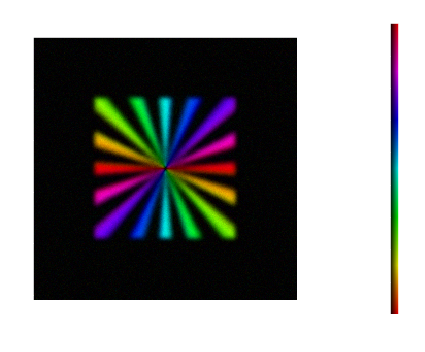

In [6]:
wo.plot_hsv([Recon_para[1,:,:,2], Recon_para[0,:,:,2]])

In [7]:
wo.hsv_stack_viewer([np.transpose(Recon_para[1],(2,0,1)), np.transpose(Recon_para[0],(2,0,1))])

interactive(children=(IntSlider(value=0, description='stack_idx', max=4), Output()), _dom_classes=('widget-int…

<function waveorder.visual.hsv_stack_viewer.<locals>.interact_plot_hsv(stack_idx)>

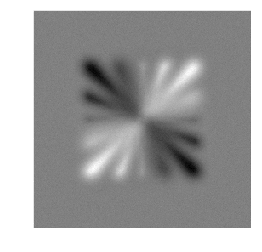

In [8]:
plt.imshow(S_image_tm[1,:,:,0],cmap='gray')

## Phase reconstruction with $S_0$

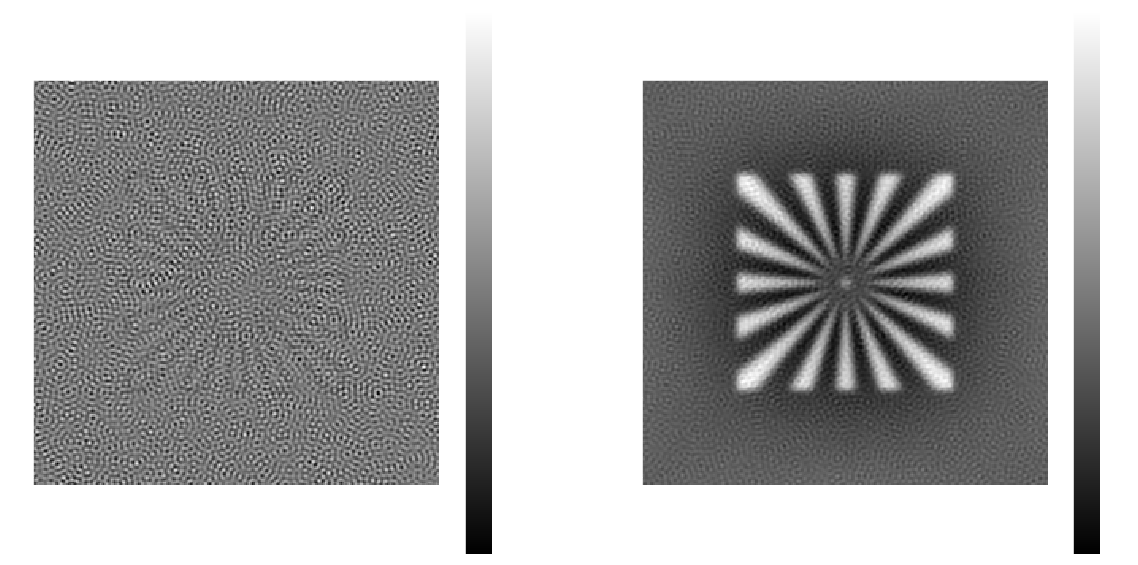

In [8]:

reg_u = 1e-3
reg_p = 1e-3
S0_stack = S_image_tm[0].copy()

mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = reg_p, use_gpu=True)

wo.plot_multicolumn(np.array([mu_sample, phi_sample]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed absorption', 'Reconstructed phase'])

Number of iteration computed (1 / 10)
Number of iteration computed (2 / 10)
Number of iteration computed (3 / 10)
Number of iteration computed (4 / 10)
Number of iteration computed (5 / 10)
Number of iteration computed (6 / 10)
Number of iteration computed (7 / 10)
Number of iteration computed (8 / 10)
Number of iteration computed (9 / 10)
Number of iteration computed (10 / 10)


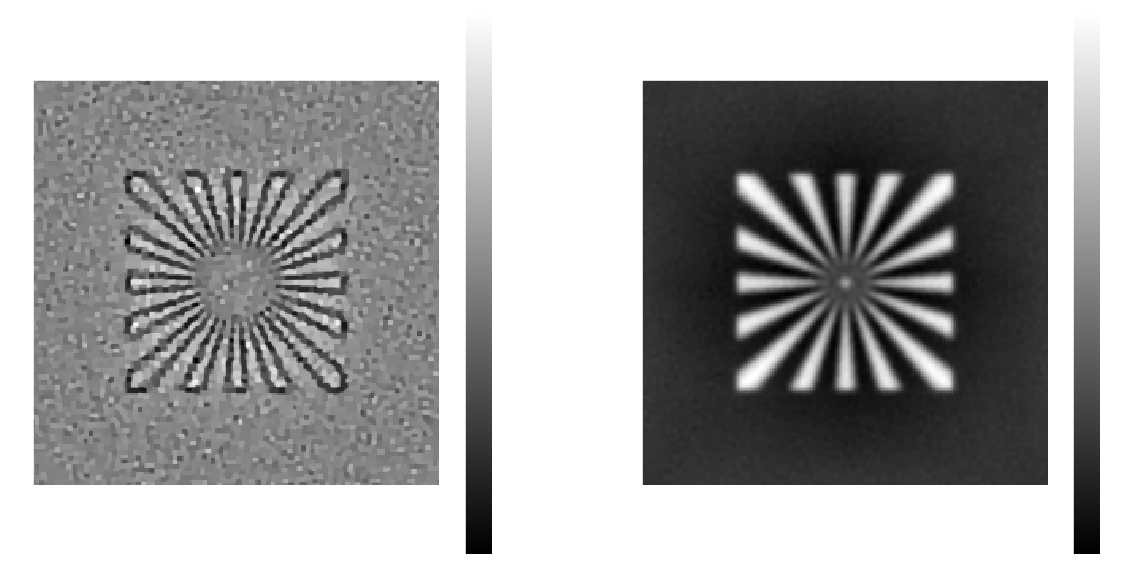

In [9]:

lambda_u = 3e-3
lambda_p = 1e-3
S0_stack = S_image_tm[0].copy()

mu_sample_TV, phi_sample_TV = setup.Phase_recon(S0_stack, method='TV', lambda_u = lambda_u, lambda_p = lambda_p, itr = 10, rho=1, use_gpu=True)

wo.plot_multicolumn(np.array([mu_sample_TV, phi_sample_TV]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed absorption', 'Reconstructed phase'])

In [27]:
%timeit mu_sample_TV, phi_sample_TV = setup.Phase_recon(S0_stack, method='TV', lambda_u = lambda_u, lambda_p = lambda_p, itr = 10, rho=1, verbose=False,use_gpu=False)


247 ms ± 7.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Birefringence reconstruction with $S_1$ and $S_2$ 
#### (Slowly varying transmission approximation)

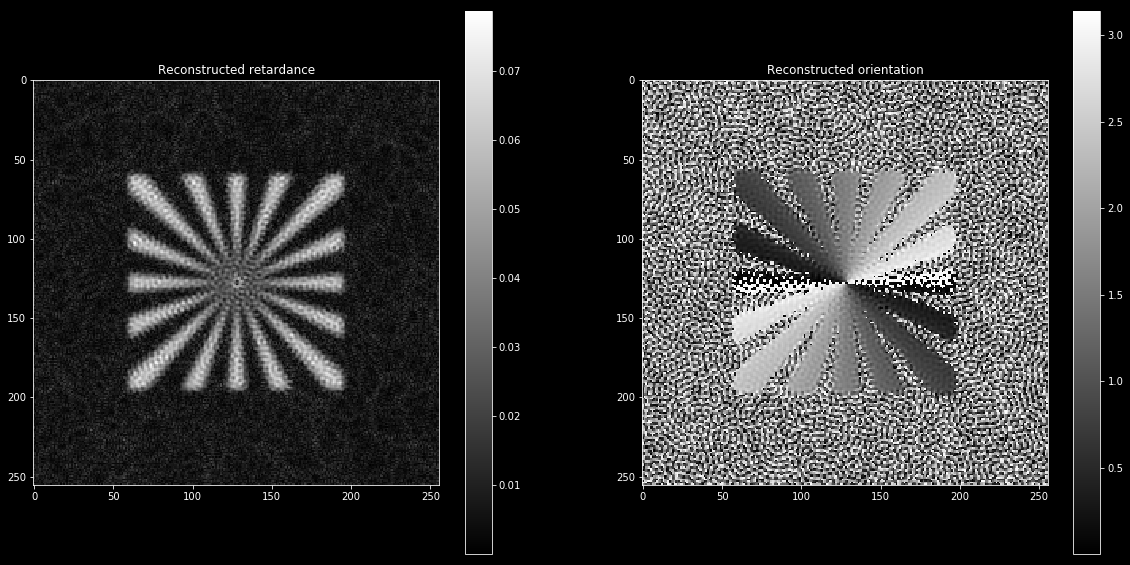

In [12]:
reg = 1e-3

S1_stack = S_image_tm[1].copy()
S2_stack = S_image_tm[2].copy()

Rt_sample, Sa_sample = setup.Birefringence_recon(S1_stack, S2_stack, reg = reg)

wo.plot_multicolumn(np.array([Rt_sample, Sa_sample]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed retardance', 'Reconstructed orientation'])


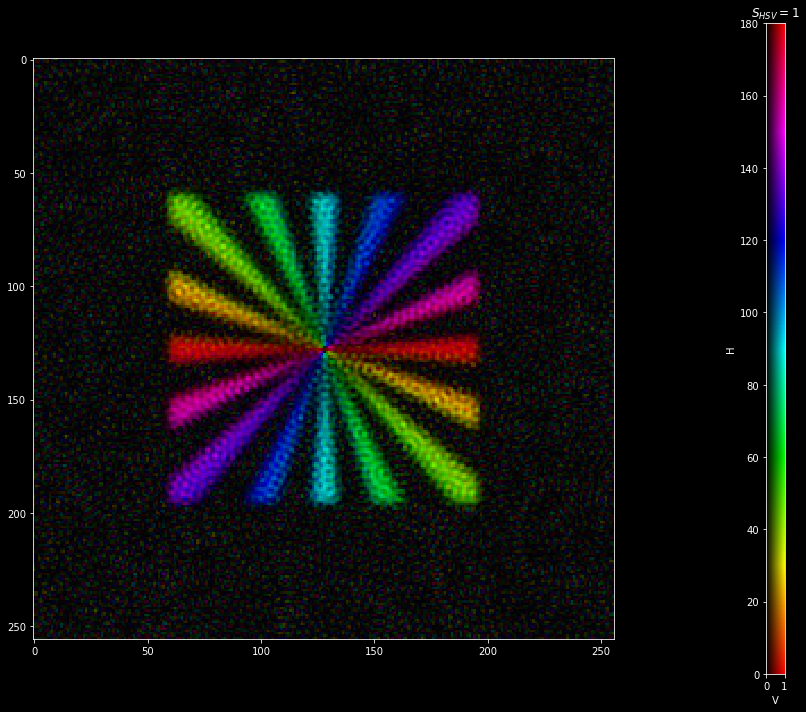

In [13]:
wo.plot_hsv([Sa_sample, Rt_sample], size=10)

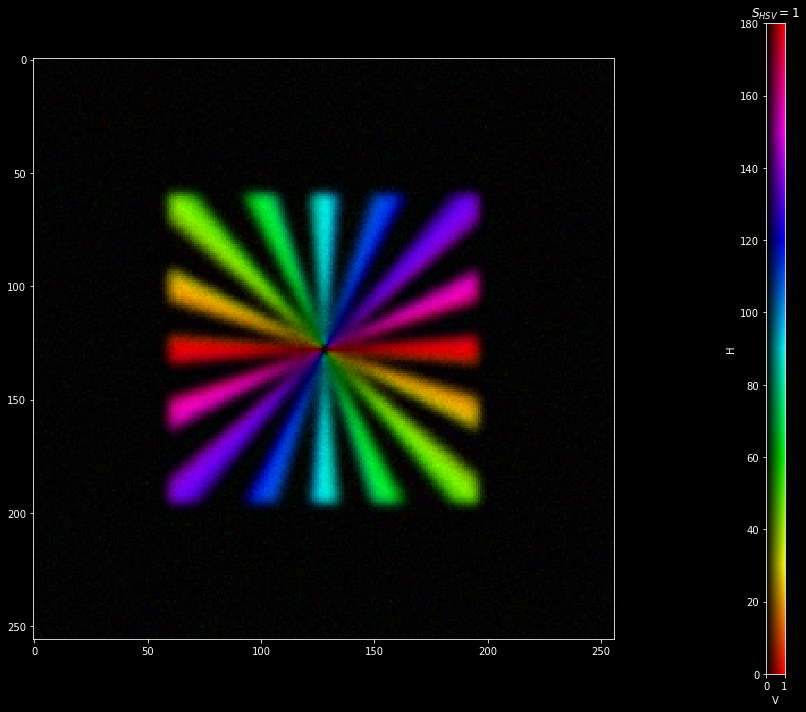

In [14]:
wo.plot_hsv([Recon_para[1,:,:,2], Recon_para[0,:,:,2]], size=10)

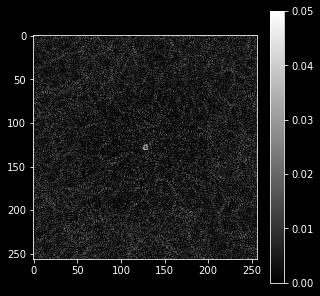

In [15]:
# Compare with the non-deconvolved birefringence recon

plt.figure(figsize=(5,5))
plt.imshow(np.abs(Recon_para[0,:,:,2]-Rt_sample), clim=(0,0.05), cmap='gray')
plt.colorbar()